In [1]:
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join('..', 'vap_sound/src')))

from utils.save_load_model import save_model_pickle, load_model_pickle
from utils.evaluate_model import evaluate_model
from vap_model import VAPModel

MODEL_PATH = os.environ.get("MODEL_PATH")
LOG_MODEL_EVALUATION = os.environ.get("LOG_MODEL_EVALUATION")
LOG_MODEL_PREDICTION = os.environ.get("LOG_MODEL_PREDICTION")

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch

# Collating data for training  --> Input is Pandas DataFrame
class VAPDataset(Dataset):
    def __init__(self, data_df, seq_length=100):
        # if isinstance(csv_files, str):
        #     csv_files = [csv_files]
        
        self.seq_length = seq_length
        # self.data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
        self.features = [torch.tensor(f) for f in data_df['features']]
        self.labels = [torch.tensor(l) for l in data_df['labels']]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        
        if feature.shape[0] > self.seq_length:
            feature = feature[-self.seq_length:]
            label = label[-self.seq_length:]
        else:
            pad_length = self.seq_length - feature.shape[0]
            feature = torch.cat([torch.zeros(pad_length, feature.shape[1]), feature], dim=0)
            label = torch.cat([torch.zeros(pad_length, label.shape[1]), label], dim=0)
        
        return feature, label

In [4]:
# Collate function to pad variable-length sequences
def collate_fn(batch):
    features, labels = zip(*batch)
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)
    return features_padded, labels_padded

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

model = VAPModel()


# Training function
def train_model(model, training_data, batch_size=16, epochs=10, seq_length=100, learning_rate = 0.01):
    """
    Train the model using the provided training data.

    Args:
        model (nn.Module): The model to train.
        training_data (pd.DataFrame): DataFrame containing 'features' and 'labels' columns.
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs to train.
        seq_length (int): Fixed sequence length for padding/truncation.
    """
    if os.path.exists(MODEL_PATH):
                model = load_model_pickle(path=MODEL_PATH)
    # Create dataset and dataloader
    train_dataset = VAPDataset(training_data, seq_length=seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0

        # Training phase
        for features, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)  # Shape: (batch_size, seq_length, 1)

            # Ensure labels have the same shape as outputs
            if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
            elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                pass  # Do nothing
            else:
                raise ValueError(f"Unexpected labels shape: {labels.shape}")



            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase (using the same data for simplicity)
        model.eval()
        with torch.no_grad():
            for features, labels in train_loader:
                outputs = model(features)

                # Ensure labels have the same shape as outputs
                if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                    labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
                elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                    pass  # Do nothing
                else:
                    raise ValueError(f"Unexpected labels shape: {labels.shape}")

                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Log training and validation loss
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(train_loader):.4f}")
    save_model_pickle(model, path=MODEL_PATH)
    print("Training complete!")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [6]:
from glob import glob
import os
import pandas as pd

data_dir = "/Users/shanujha/Desktop/voice_activity_prediction/voice_data_mozilla/en/clips"
audio_files = glob(os.path.join(data_dir, "*.mp3"))


CSV_FILE_PATH = "/Users/shanujha/Desktop/voice_activity_prediction/logs/trained_mp3_files.csv"


data = {"file_paths": audio_files, "processed": [0 for i in range(len(audio_files))]}
file_df = pd.DataFrame(data)
# csv_df.to_csv(CSV_FILE_PATH, index=False)

# file_df = pd.read_csv(CSV_FILE_PATH)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [disable_jit_profiling, allow_tf32]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:5: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import VAD
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/vad

Epoch 1/15, Train Loss: 0.5894, Val Loss: 0.5022
Epoch 2/15, Train Loss: 0.4630, Val Loss: 0.4618
Epoch 3/15, Train Loss: 0.4262, Val Loss: 0.4162
Epoch 4/15, Train Loss: 0.4332, Val Loss: 0.4808
Epoch 5/15, Train Loss: 0.4379, Val Loss: 0.4240
Epoch 6/15, Train Loss: 0.4080, Val Loss: 0.5582
Epoch 7/15, Train Loss: 0.4403, Val Loss: 0.3988
Epoch 8/15, Train Loss: 0.4001, Val Loss: 0.3889
Epoch 9/15, Train Loss: 0.4120, Val Loss: 0.3850
Epoch 10/15, Train Loss: 0.3850, Val Loss: 0.3775
Epoch 11/15, Train Loss: 0.3814, Val Loss: 0.3743
Epoch 12/15, Train Loss: 0.3850, Val Loss: 0.3724
Epoch 13/15, Train Loss: 0.3726, Val Loss: 0.3884
Epoch 14/15, Train Loss: 0.3742, Val Loss: 0.3825
Epoch 15/15, Train Loss: 0.3801, Val Loss: 0.3804
Model saved successfully as pickle file!
Training complete!


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Test Accuracy: 0.8071
Confusion Matrix:
[[15493  1273]
 [ 4513  8721]]


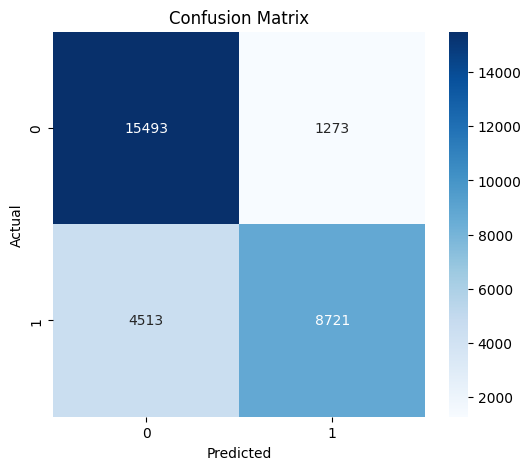

BATCH 1 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.4124, Val Loss: 0.3961
Epoch 2/15, Train Loss: 0.4040, Val Loss: 0.3909
Epoch 3/15, Train Loss: 0.3894, Val Loss: 0.3787
Epoch 4/15, Train Loss: 0.3923, Val Loss: 0.3853
Epoch 5/15, Train Loss: 0.3883, Val Loss: 0.3833
Epoch 6/15, Train Loss: 0.3823, Val Loss: 0.3660
Epoch 7/15, Train Loss: 0.3887, Val Loss: 0.3867
Epoch 8/15, Train Loss: 0.3760, Val Loss: 0.3774
Epoch 9/15, Train Loss: 0.3804, Val Loss: 0.3615
Epoch 10/15, Train Loss: 0.3696, Val Loss: 0.3709
Epoch 11/15, Train Loss: 0.3722, Val Loss: 0.3546
Epoch 12/15, Train Loss: 0.3709, Val Loss: 0.3787
Epoch 13/15, Train Loss: 0.3703, Val Loss: 0.3839
Epoch 14/15, Train Loss: 0.3742, Val Loss: 0.3575
Epoch 15/15, Train Loss: 0.3636, Val Loss: 0.3501
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8143
Confusion Matrix:
[[16122  1153]
 [ 4418  8307]]


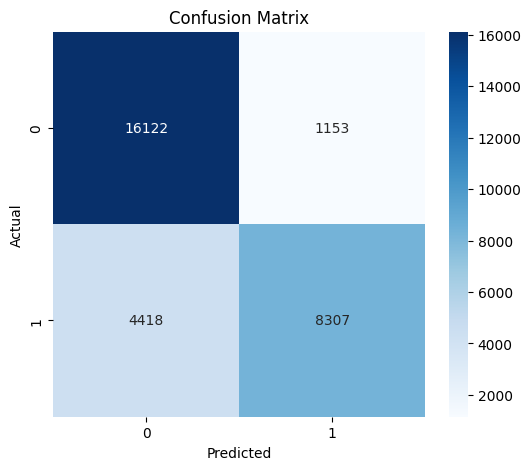

BATCH 2 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3924, Val Loss: 0.3828
Epoch 2/15, Train Loss: 0.3702, Val Loss: 0.3702
Epoch 3/15, Train Loss: 0.3678, Val Loss: 0.3556
Epoch 4/15, Train Loss: 0.3652, Val Loss: 0.3552
Epoch 5/15, Train Loss: 0.3575, Val Loss: 0.3537
Epoch 6/15, Train Loss: 0.3568, Val Loss: 0.3480
Epoch 7/15, Train Loss: 0.3561, Val Loss: 0.3549
Epoch 8/15, Train Loss: 0.3639, Val Loss: 0.3515
Epoch 9/15, Train Loss: 0.3487, Val Loss: 0.3437
Epoch 10/15, Train Loss: 0.3428, Val Loss: 0.3340
Epoch 11/15, Train Loss: 0.3477, Val Loss: 0.3456
Epoch 12/15, Train Loss: 0.3603, Val Loss: 0.3507
Epoch 13/15, Train Loss: 0.3427, Val Loss: 0.3512
Epoch 14/15, Train Loss: 0.3435, Val Loss: 0.3428
Epoch 15/15, Train Loss: 0.3434, Val Loss: 0.3392
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8201
Confusion Matrix:
[[16383   956]
 [ 4442  8219]]


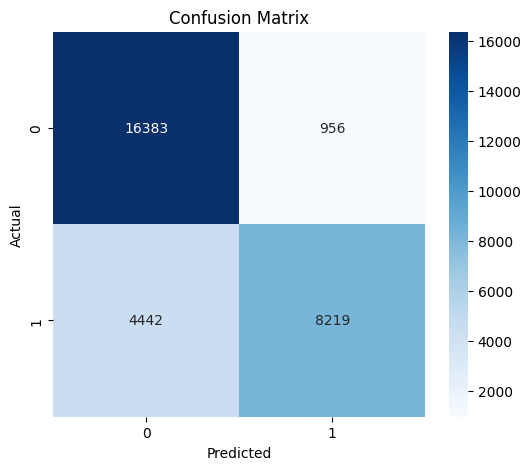

BATCH 3 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3908, Val Loss: 0.3697
Epoch 2/15, Train Loss: 0.3617, Val Loss: 0.3594
Epoch 3/15, Train Loss: 0.3461, Val Loss: 0.3470
Epoch 4/15, Train Loss: 0.3416, Val Loss: 0.3444
Epoch 5/15, Train Loss: 0.3543, Val Loss: 0.3347
Epoch 6/15, Train Loss: 0.3393, Val Loss: 0.3325
Epoch 7/15, Train Loss: 0.3380, Val Loss: 0.3316
Epoch 8/15, Train Loss: 0.3421, Val Loss: 0.3307
Epoch 9/15, Train Loss: 0.3510, Val Loss: 0.3318
Epoch 10/15, Train Loss: 0.3351, Val Loss: 0.3205
Epoch 11/15, Train Loss: 0.3309, Val Loss: 0.3228
Epoch 12/15, Train Loss: 0.3332, Val Loss: 0.3343
Epoch 13/15, Train Loss: 0.3334, Val Loss: 0.3501
Epoch 14/15, Train Loss: 0.3643, Val Loss: 0.3406
Epoch 15/15, Train Loss: 0.3558, Val Loss: 0.3238
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8201
Confusion Matrix:
[[15823  1306]
 [ 4090  8781]]


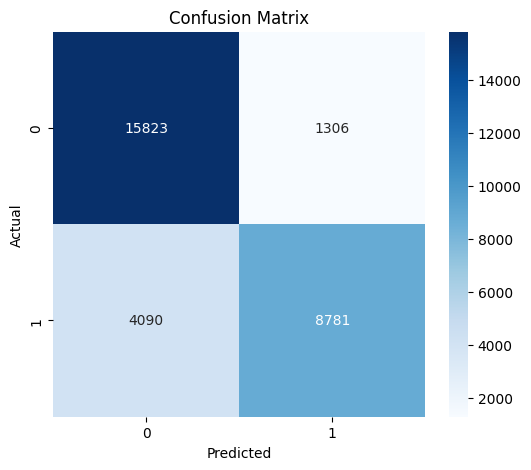

BATCH 4 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3680, Val Loss: 0.3439
Epoch 2/15, Train Loss: 0.3544, Val Loss: 0.3464
Epoch 3/15, Train Loss: 0.3629, Val Loss: 0.3525
Epoch 4/15, Train Loss: 0.3508, Val Loss: 0.3311
Epoch 5/15, Train Loss: 0.3490, Val Loss: 0.3466
Epoch 6/15, Train Loss: 0.3512, Val Loss: 0.3241
Epoch 7/15, Train Loss: 0.3283, Val Loss: 0.3245
Epoch 8/15, Train Loss: 0.3403, Val Loss: 0.3173
Epoch 9/15, Train Loss: 0.3409, Val Loss: 0.3313
Epoch 10/15, Train Loss: 0.3378, Val Loss: 0.3156
Epoch 11/15, Train Loss: 0.3302, Val Loss: 0.3263
Epoch 12/15, Train Loss: 0.3316, Val Loss: 0.3108
Epoch 13/15, Train Loss: 0.3223, Val Loss: 0.3091
Epoch 14/15, Train Loss: 0.3121, Val Loss: 0.3086
Epoch 15/15, Train Loss: 0.3350, Val Loss: 0.3306
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8175
Confusion Matrix:
[[16711  1131]
 [ 4345  7813]]


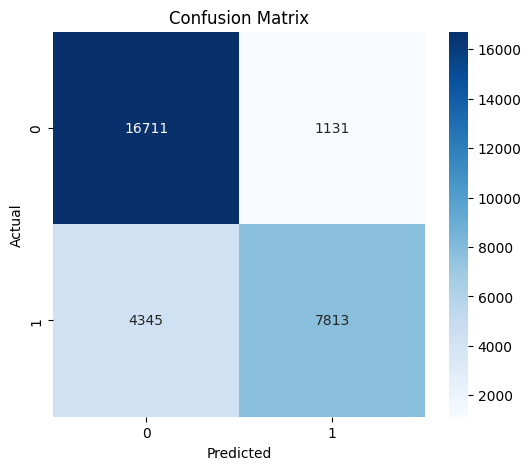

BATCH 5 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3838, Val Loss: 0.3682
Epoch 2/15, Train Loss: 0.3764, Val Loss: 0.3555
Epoch 3/15, Train Loss: 0.3620, Val Loss: 0.3516
Epoch 4/15, Train Loss: 0.3597, Val Loss: 0.3562
Epoch 5/15, Train Loss: 0.3630, Val Loss: 0.3440
Epoch 6/15, Train Loss: 0.3509, Val Loss: 0.3489
Epoch 7/15, Train Loss: 0.3486, Val Loss: 0.3398
Epoch 8/15, Train Loss: 0.3549, Val Loss: 0.3615
Epoch 9/15, Train Loss: 0.3649, Val Loss: 0.3435
Epoch 10/15, Train Loss: 0.3487, Val Loss: 0.3512
Epoch 11/15, Train Loss: 0.3523, Val Loss: 0.3730
Epoch 12/15, Train Loss: 0.3434, Val Loss: 0.3336
Epoch 13/15, Train Loss: 0.3415, Val Loss: 0.3239
Epoch 14/15, Train Loss: 0.3295, Val Loss: 0.3343
Epoch 15/15, Train Loss: 0.3278, Val Loss: 0.3223
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8359
Confusion Matrix:
[[17403  1145]
 [ 3779  7673]]


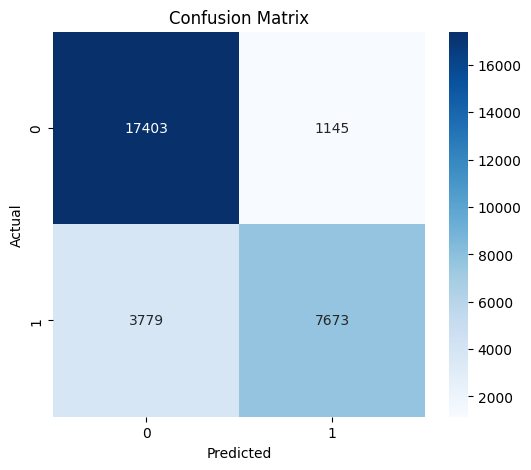

BATCH 6 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3745, Val Loss: 0.3520
Epoch 2/15, Train Loss: 0.3483, Val Loss: 0.3336
Epoch 3/15, Train Loss: 0.3522, Val Loss: 0.3324
Epoch 4/15, Train Loss: 0.3358, Val Loss: 0.3343
Epoch 5/15, Train Loss: 0.3384, Val Loss: 0.3327
Epoch 6/15, Train Loss: 0.3241, Val Loss: 0.3191
Epoch 7/15, Train Loss: 0.3217, Val Loss: 0.3026
Epoch 8/15, Train Loss: 0.3180, Val Loss: 0.3148
Epoch 9/15, Train Loss: 0.3182, Val Loss: 0.3408
Epoch 10/15, Train Loss: 0.3268, Val Loss: 0.3165
Epoch 11/15, Train Loss: 0.3229, Val Loss: 0.3179
Epoch 12/15, Train Loss: 0.3240, Val Loss: 0.2951
Epoch 13/15, Train Loss: 0.3050, Val Loss: 0.3105
Epoch 14/15, Train Loss: 0.3153, Val Loss: 0.2937
Epoch 15/15, Train Loss: 0.3134, Val Loss: 0.3157
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8199
Confusion Matrix:
[[16883  1182]
 [ 4222  7713]]


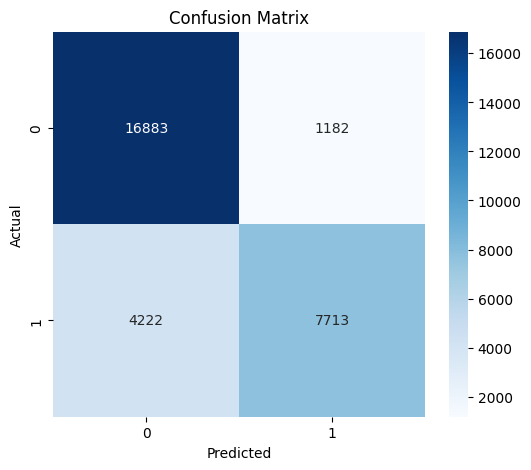

BATCH 7 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3646, Val Loss: 0.3559
Epoch 2/15, Train Loss: 0.3628, Val Loss: 0.3552
Epoch 3/15, Train Loss: 0.3501, Val Loss: 0.3418
Epoch 4/15, Train Loss: 0.3498, Val Loss: 0.3350
Epoch 5/15, Train Loss: 0.3358, Val Loss: 0.3404
Epoch 6/15, Train Loss: 0.3336, Val Loss: 0.3205
Epoch 7/15, Train Loss: 0.3366, Val Loss: 0.3306
Epoch 8/15, Train Loss: 0.3391, Val Loss: 0.3247
Epoch 9/15, Train Loss: 0.3304, Val Loss: 0.3176
Epoch 10/15, Train Loss: 0.3252, Val Loss: 0.3504
Epoch 11/15, Train Loss: 0.3327, Val Loss: 0.3281
Epoch 12/15, Train Loss: 0.3368, Val Loss: 0.3368
Epoch 13/15, Train Loss: 0.3258, Val Loss: 0.3221
Epoch 14/15, Train Loss: 0.3337, Val Loss: 0.3278
Epoch 15/15, Train Loss: 0.3169, Val Loss: 0.3042
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8129
Confusion Matrix:
[[15983  1095]
 [ 4518  8404]]


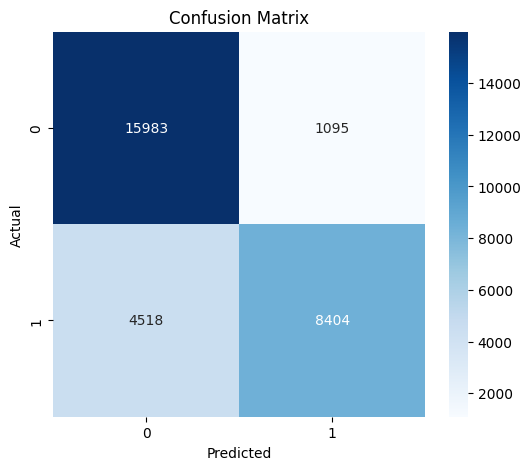

BATCH 8 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3659, Val Loss: 0.3407
Epoch 2/15, Train Loss: 0.3456, Val Loss: 0.3310
Epoch 3/15, Train Loss: 0.3415, Val Loss: 0.3242
Epoch 4/15, Train Loss: 0.3304, Val Loss: 0.3191
Epoch 5/15, Train Loss: 0.3242, Val Loss: 0.3212
Epoch 6/15, Train Loss: 0.3148, Val Loss: 0.3136
Epoch 7/15, Train Loss: 0.3274, Val Loss: 0.3180
Epoch 8/15, Train Loss: 0.3187, Val Loss: 0.3003
Epoch 9/15, Train Loss: 0.3070, Val Loss: 0.2972
Epoch 10/15, Train Loss: 0.3040, Val Loss: 0.3072
Epoch 11/15, Train Loss: 0.3219, Val Loss: 0.3037
Epoch 12/15, Train Loss: 0.3106, Val Loss: 0.3211
Epoch 13/15, Train Loss: 0.3066, Val Loss: 0.2897
Epoch 14/15, Train Loss: 0.3142, Val Loss: 0.2956
Epoch 15/15, Train Loss: 0.3171, Val Loss: 0.3064
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8028
Confusion Matrix:
[[15460  1424]
 [ 4493  8623]]


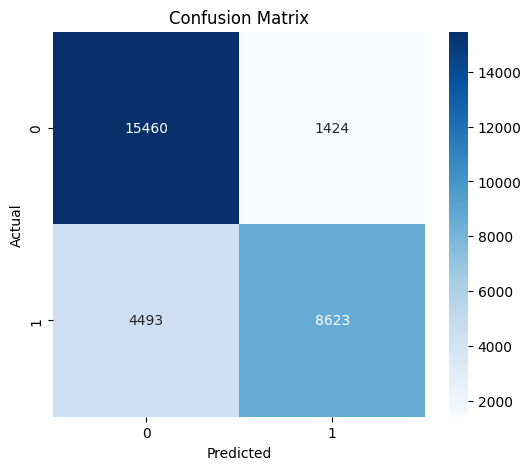

BATCH 9 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3419, Val Loss: 0.3249
Epoch 2/15, Train Loss: 0.3241, Val Loss: 0.3124
Epoch 3/15, Train Loss: 0.3247, Val Loss: 0.3120
Epoch 4/15, Train Loss: 0.3123, Val Loss: 0.3182
Epoch 5/15, Train Loss: 0.3115, Val Loss: 0.2955
Epoch 6/15, Train Loss: 0.3011, Val Loss: 0.3183
Epoch 7/15, Train Loss: 0.3116, Val Loss: 0.3262
Epoch 8/15, Train Loss: 0.3127, Val Loss: 0.3074
Epoch 9/15, Train Loss: 0.2969, Val Loss: 0.2897
Epoch 10/15, Train Loss: 0.3081, Val Loss: 0.2918
Epoch 11/15, Train Loss: 0.2989, Val Loss: 0.2976
Epoch 12/15, Train Loss: 0.2948, Val Loss: 0.2813
Epoch 13/15, Train Loss: 0.2940, Val Loss: 0.2866
Epoch 14/15, Train Loss: 0.2987, Val Loss: 0.2992
Epoch 15/15, Train Loss: 0.2874, Val Loss: 0.2712
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8063
Confusion Matrix:
[[15853   992]
 [ 4820  8335]]


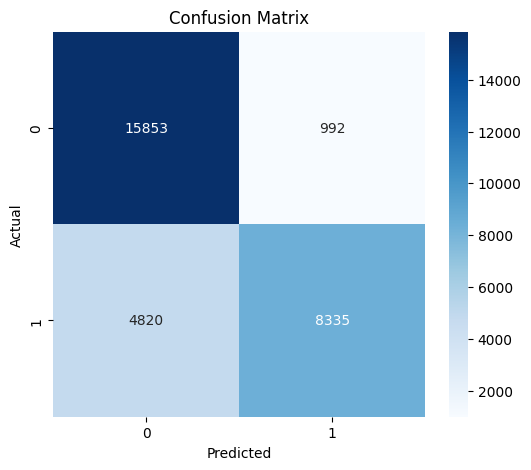

BATCH 10 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3892, Val Loss: 0.3628
Epoch 2/15, Train Loss: 0.3600, Val Loss: 0.3655
Epoch 3/15, Train Loss: 0.3552, Val Loss: 0.3447
Epoch 4/15, Train Loss: 0.3510, Val Loss: 0.3659
Epoch 5/15, Train Loss: 0.3489, Val Loss: 0.3343
Epoch 6/15, Train Loss: 0.3419, Val Loss: 0.3287
Epoch 7/15, Train Loss: 0.3344, Val Loss: 0.3436
Epoch 8/15, Train Loss: 0.3275, Val Loss: 0.3309
Epoch 9/15, Train Loss: 0.3275, Val Loss: 0.3183
Epoch 10/15, Train Loss: 0.3193, Val Loss: 0.3034
Epoch 11/15, Train Loss: 0.3246, Val Loss: 0.3166
Epoch 12/15, Train Loss: 0.3267, Val Loss: 0.3112
Epoch 13/15, Train Loss: 0.3166, Val Loss: 0.3048
Epoch 14/15, Train Loss: 0.3171, Val Loss: 0.3001
Epoch 15/15, Train Loss: 0.3167, Val Loss: 0.3095
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8161
Confusion Matrix:
[[16190   896]
 [ 4622  8292]]


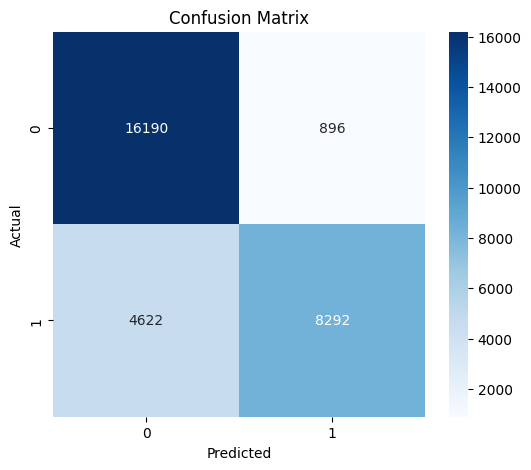

BATCH 11 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3462, Val Loss: 0.3238
Epoch 2/15, Train Loss: 0.3193, Val Loss: 0.3120
Epoch 3/15, Train Loss: 0.3133, Val Loss: 0.3098
Epoch 4/15, Train Loss: 0.3042, Val Loss: 0.2883
Epoch 5/15, Train Loss: 0.2945, Val Loss: 0.2992
Epoch 6/15, Train Loss: 0.2981, Val Loss: 0.2854
Epoch 7/15, Train Loss: 0.2961, Val Loss: 0.2931
Epoch 8/15, Train Loss: 0.2909, Val Loss: 0.2939
Epoch 9/15, Train Loss: 0.2801, Val Loss: 0.2803
Epoch 10/15, Train Loss: 0.2779, Val Loss: 0.2747
Epoch 11/15, Train Loss: 0.2807, Val Loss: 0.2616
Epoch 12/15, Train Loss: 0.2733, Val Loss: 0.2812
Epoch 13/15, Train Loss: 0.2706, Val Loss: 0.2647
Epoch 14/15, Train Loss: 0.2732, Val Loss: 0.2631
Epoch 15/15, Train Loss: 0.2853, Val Loss: 0.2897
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8218
Confusion Matrix:
[[16830  1024]
 [ 4321  7825]]


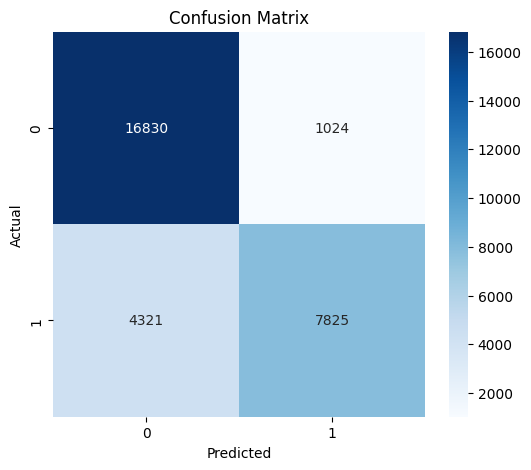

BATCH 12 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3531, Val Loss: 0.3364
Epoch 2/15, Train Loss: 0.3305, Val Loss: 0.3432
Epoch 3/15, Train Loss: 0.3300, Val Loss: 0.3139
Epoch 4/15, Train Loss: 0.3178, Val Loss: 0.3126
Epoch 5/15, Train Loss: 0.3066, Val Loss: 0.3102
Epoch 6/15, Train Loss: 0.2999, Val Loss: 0.2973
Epoch 7/15, Train Loss: 0.2982, Val Loss: 0.3005
Epoch 8/15, Train Loss: 0.3035, Val Loss: 0.2968
Epoch 9/15, Train Loss: 0.2995, Val Loss: 0.2964
Epoch 10/15, Train Loss: 0.2990, Val Loss: 0.2797
Epoch 11/15, Train Loss: 0.2899, Val Loss: 0.2835
Epoch 12/15, Train Loss: 0.2804, Val Loss: 0.2682
Epoch 13/15, Train Loss: 0.2763, Val Loss: 0.2744
Epoch 14/15, Train Loss: 0.3017, Val Loss: 0.3060
Epoch 15/15, Train Loss: 0.2938, Val Loss: 0.2885
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8069
Confusion Matrix:
[[16235  1209]
 [ 4584  7972]]


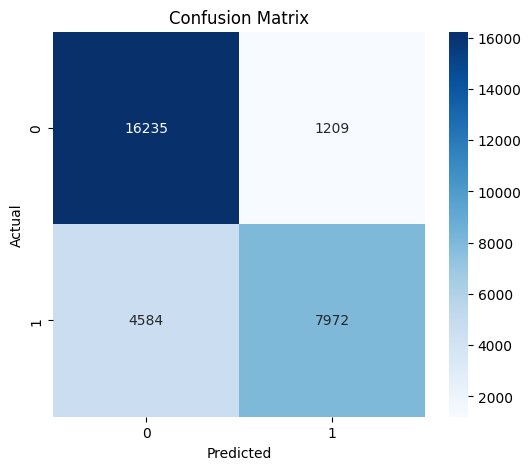

BATCH 13 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3480, Val Loss: 0.3216
Epoch 2/15, Train Loss: 0.3281, Val Loss: 0.3326
Epoch 3/15, Train Loss: 0.3120, Val Loss: 0.3087
Epoch 4/15, Train Loss: 0.2995, Val Loss: 0.3036
Epoch 5/15, Train Loss: 0.3157, Val Loss: 0.2896
Epoch 6/15, Train Loss: 0.2995, Val Loss: 0.2925
Epoch 7/15, Train Loss: 0.2942, Val Loss: 0.3179
Epoch 8/15, Train Loss: 0.3041, Val Loss: 0.2816
Epoch 9/15, Train Loss: 0.2895, Val Loss: 0.2772
Epoch 10/15, Train Loss: 0.2814, Val Loss: 0.2658
Epoch 11/15, Train Loss: 0.2723, Val Loss: 0.2676
Epoch 12/15, Train Loss: 0.2734, Val Loss: 0.2575
Epoch 13/15, Train Loss: 0.2688, Val Loss: 0.2675
Epoch 14/15, Train Loss: 0.2664, Val Loss: 0.2572
Epoch 15/15, Train Loss: 0.2574, Val Loss: 0.2704
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8343
Confusion Matrix:
[[17338  1152]
 [ 3820  7690]]


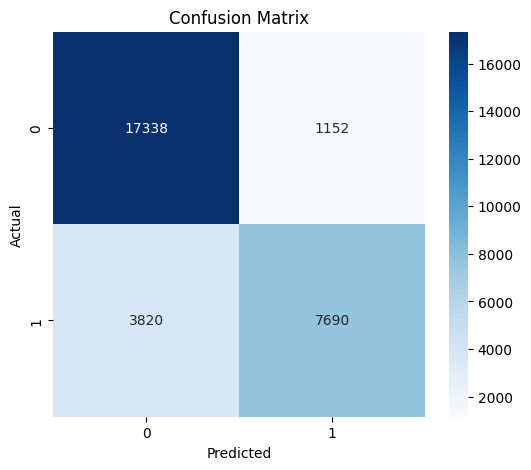

BATCH 14 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.4053, Val Loss: 0.3606
Epoch 2/15, Train Loss: 0.3578, Val Loss: 0.3410
Epoch 3/15, Train Loss: 0.3433, Val Loss: 0.3335
Epoch 4/15, Train Loss: 0.3349, Val Loss: 0.3283
Epoch 5/15, Train Loss: 0.3312, Val Loss: 0.3131
Epoch 6/15, Train Loss: 0.3397, Val Loss: 0.3200
Epoch 7/15, Train Loss: 0.3289, Val Loss: 0.3106
Epoch 8/15, Train Loss: 0.3208, Val Loss: 0.3024
Epoch 9/15, Train Loss: 0.3114, Val Loss: 0.3038
Epoch 10/15, Train Loss: 0.3039, Val Loss: 0.2907
Epoch 11/15, Train Loss: 0.3032, Val Loss: 0.2955
Epoch 12/15, Train Loss: 0.3031, Val Loss: 0.3002
Epoch 13/15, Train Loss: 0.3282, Val Loss: 0.3177
Epoch 14/15, Train Loss: 0.3052, Val Loss: 0.2898
Epoch 15/15, Train Loss: 0.3008, Val Loss: 0.2979
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8096
Confusion Matrix:
[[16081  1219]
 [ 4492  8208]]


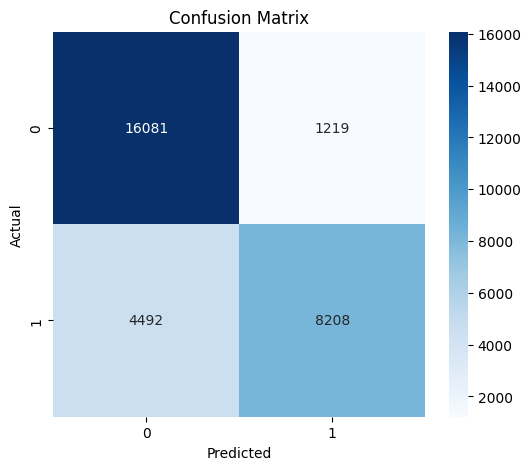

BATCH 15 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3736, Val Loss: 0.3505
Epoch 2/15, Train Loss: 0.3462, Val Loss: 0.3329
Epoch 3/15, Train Loss: 0.3324, Val Loss: 0.3220
Epoch 4/15, Train Loss: 0.3278, Val Loss: 0.3141
Epoch 5/15, Train Loss: 0.3155, Val Loss: 0.3088
Epoch 6/15, Train Loss: 0.3161, Val Loss: 0.2997
Epoch 7/15, Train Loss: 0.3135, Val Loss: 0.2997
Epoch 8/15, Train Loss: 0.3093, Val Loss: 0.3061
Epoch 9/15, Train Loss: 0.3059, Val Loss: 0.3112
Epoch 10/15, Train Loss: 0.3176, Val Loss: 0.3214
Epoch 11/15, Train Loss: 0.3107, Val Loss: 0.2923
Epoch 12/15, Train Loss: 0.2984, Val Loss: 0.2921
Epoch 13/15, Train Loss: 0.3034, Val Loss: 0.2867
Epoch 14/15, Train Loss: 0.2907, Val Loss: 0.2764
Epoch 15/15, Train Loss: 0.2906, Val Loss: 0.2719
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8071
Confusion Matrix:
[[16837  1229]
 [ 4557  7377]]


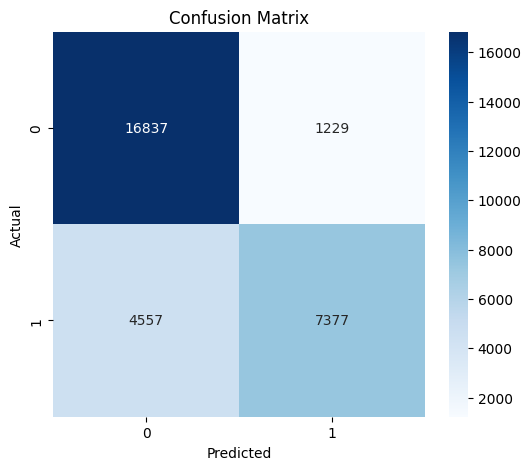

BATCH 16 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3550, Val Loss: 0.3404
Epoch 2/15, Train Loss: 0.3340, Val Loss: 0.3151
Epoch 3/15, Train Loss: 0.3146, Val Loss: 0.3154
Epoch 4/15, Train Loss: 0.3046, Val Loss: 0.2837
Epoch 5/15, Train Loss: 0.2964, Val Loss: 0.2771
Epoch 6/15, Train Loss: 0.2778, Val Loss: 0.2769
Epoch 7/15, Train Loss: 0.2842, Val Loss: 0.2877
Epoch 8/15, Train Loss: 0.2852, Val Loss: 0.2891
Epoch 9/15, Train Loss: 0.2766, Val Loss: 0.2550
Epoch 10/15, Train Loss: 0.2741, Val Loss: 0.2729
Epoch 11/15, Train Loss: 0.2906, Val Loss: 0.2663
Epoch 12/15, Train Loss: 0.2739, Val Loss: 0.2831
Epoch 13/15, Train Loss: 0.2955, Val Loss: 0.2716
Epoch 14/15, Train Loss: 0.2679, Val Loss: 0.2621
Epoch 15/15, Train Loss: 0.2640, Val Loss: 0.2634
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8221
Confusion Matrix:
[[16885  1141]
 [ 4196  7778]]


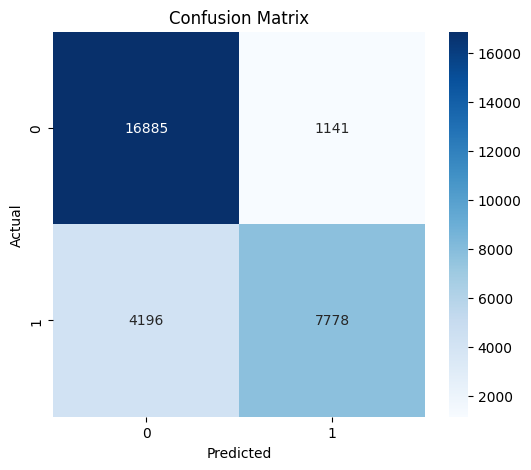

BATCH 17 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3752, Val Loss: 0.3506
Epoch 2/15, Train Loss: 0.3446, Val Loss: 0.3221
Epoch 3/15, Train Loss: 0.3371, Val Loss: 0.3135
Epoch 4/15, Train Loss: 0.3148, Val Loss: 0.3084
Epoch 5/15, Train Loss: 0.3061, Val Loss: 0.2894
Epoch 6/15, Train Loss: 0.3076, Val Loss: 0.2943
Epoch 7/15, Train Loss: 0.3050, Val Loss: 0.2971
Epoch 8/15, Train Loss: 0.3045, Val Loss: 0.2839
Epoch 9/15, Train Loss: 0.2812, Val Loss: 0.2787
Epoch 10/15, Train Loss: 0.2974, Val Loss: 0.2903
Epoch 11/15, Train Loss: 0.2859, Val Loss: 0.2695
Epoch 12/15, Train Loss: 0.2747, Val Loss: 0.2739
Epoch 13/15, Train Loss: 0.2773, Val Loss: 0.2743
Epoch 14/15, Train Loss: 0.2799, Val Loss: 0.2582
Epoch 15/15, Train Loss: 0.2614, Val Loss: 0.2562
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8133
Confusion Matrix:
[[15772  1119]
 [ 4482  8627]]


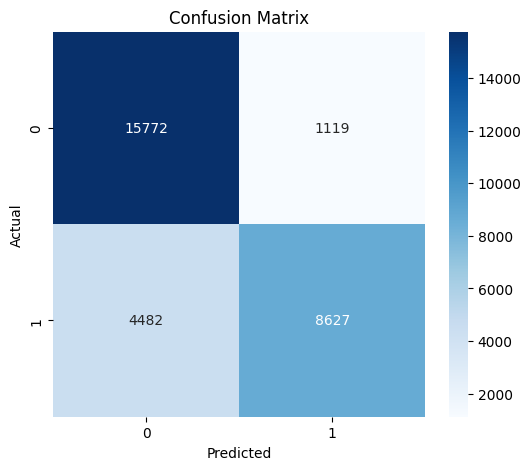

BATCH 18 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3725, Val Loss: 0.3470
Epoch 2/15, Train Loss: 0.3380, Val Loss: 0.3261
Epoch 3/15, Train Loss: 0.3248, Val Loss: 0.3164
Epoch 4/15, Train Loss: 0.3245, Val Loss: 0.3174
Epoch 5/15, Train Loss: 0.3222, Val Loss: 0.3086
Epoch 6/15, Train Loss: 0.3096, Val Loss: 0.3179
Epoch 7/15, Train Loss: 0.3147, Val Loss: 0.2971
Epoch 8/15, Train Loss: 0.3063, Val Loss: 0.2963
Epoch 9/15, Train Loss: 0.3000, Val Loss: 0.2854
Epoch 10/15, Train Loss: 0.3019, Val Loss: 0.2877
Epoch 11/15, Train Loss: 0.2915, Val Loss: 0.2830
Epoch 12/15, Train Loss: 0.2986, Val Loss: 0.2857
Epoch 13/15, Train Loss: 0.2968, Val Loss: 0.2758
Epoch 14/15, Train Loss: 0.2962, Val Loss: 0.2830
Epoch 15/15, Train Loss: 0.2953, Val Loss: 0.2891
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8282
Confusion Matrix:
[[16397  1066]
 [ 4089  8448]]


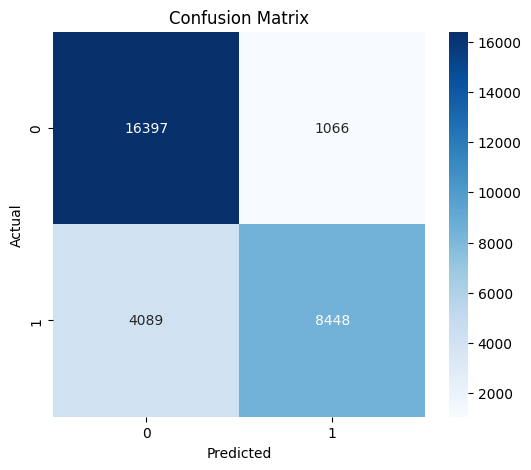

BATCH 19 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3463, Val Loss: 0.3296
Epoch 2/15, Train Loss: 0.3193, Val Loss: 0.3147
Epoch 3/15, Train Loss: 0.3061, Val Loss: 0.3004
Epoch 4/15, Train Loss: 0.3029, Val Loss: 0.2938
Epoch 5/15, Train Loss: 0.2970, Val Loss: 0.2848
Epoch 6/15, Train Loss: 0.2981, Val Loss: 0.2814
Epoch 7/15, Train Loss: 0.2864, Val Loss: 0.2691
Epoch 8/15, Train Loss: 0.2767, Val Loss: 0.2592
Epoch 9/15, Train Loss: 0.2819, Val Loss: 0.2660
Epoch 10/15, Train Loss: 0.2765, Val Loss: 0.2617
Epoch 11/15, Train Loss: 0.2765, Val Loss: 0.2650
Epoch 12/15, Train Loss: 0.2687, Val Loss: 0.2557
Epoch 13/15, Train Loss: 0.2639, Val Loss: 0.2455
Epoch 14/15, Train Loss: 0.2696, Val Loss: 0.2699
Epoch 15/15, Train Loss: 0.2722, Val Loss: 0.2483
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8187
Confusion Matrix:
[[15945   725]
 [ 4713  8617]]


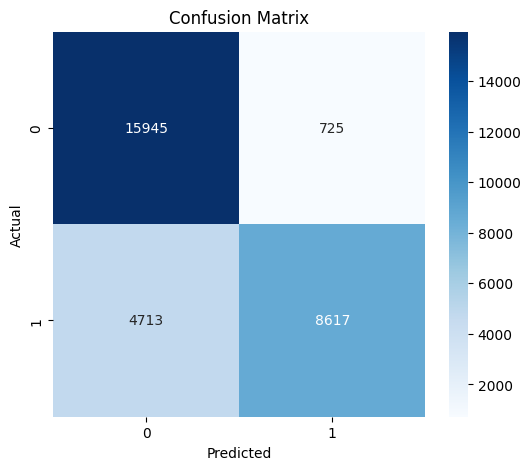

BATCH 20 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3824, Val Loss: 0.3446
Epoch 2/15, Train Loss: 0.3433, Val Loss: 0.3273
Epoch 3/15, Train Loss: 0.3324, Val Loss: 0.3300
Epoch 4/15, Train Loss: 0.3323, Val Loss: 0.3291
Epoch 5/15, Train Loss: 0.3252, Val Loss: 0.3064
Epoch 6/15, Train Loss: 0.3133, Val Loss: 0.3032
Epoch 7/15, Train Loss: 0.3101, Val Loss: 0.3168
Epoch 8/15, Train Loss: 0.3181, Val Loss: 0.3187
Epoch 9/15, Train Loss: 0.3195, Val Loss: 0.2952
Epoch 10/15, Train Loss: 0.3018, Val Loss: 0.2855
Epoch 11/15, Train Loss: 0.2923, Val Loss: 0.2797
Epoch 12/15, Train Loss: 0.2898, Val Loss: 0.2736
Epoch 13/15, Train Loss: 0.2825, Val Loss: 0.2783
Epoch 14/15, Train Loss: 0.2856, Val Loss: 0.2918
Epoch 15/15, Train Loss: 0.2921, Val Loss: 0.2863
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.7989
Confusion Matrix:
[[15775  1557]
 [ 4475  8193]]


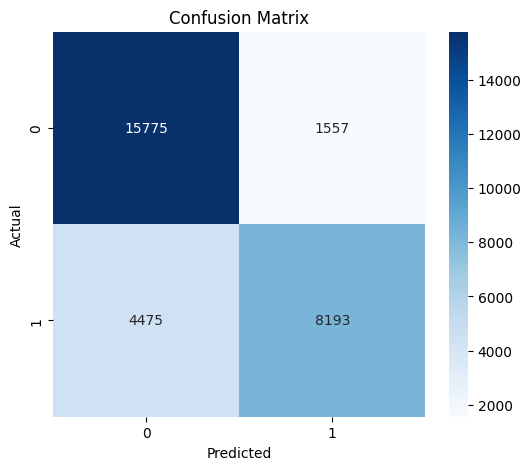

BATCH 21 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3789, Val Loss: 0.3467
Epoch 2/15, Train Loss: 0.3407, Val Loss: 0.3288
Epoch 3/15, Train Loss: 0.3434, Val Loss: 0.3396
Epoch 4/15, Train Loss: 0.3310, Val Loss: 0.3100
Epoch 5/15, Train Loss: 0.3231, Val Loss: 0.3006
Epoch 6/15, Train Loss: 0.3099, Val Loss: 0.3073
Epoch 7/15, Train Loss: 0.3036, Val Loss: 0.2896
Epoch 8/15, Train Loss: 0.2963, Val Loss: 0.2988
Epoch 9/15, Train Loss: 0.2880, Val Loss: 0.2787
Epoch 10/15, Train Loss: 0.2823, Val Loss: 0.2686
Epoch 11/15, Train Loss: 0.2782, Val Loss: 0.2649
Epoch 12/15, Train Loss: 0.2784, Val Loss: 0.2741
Epoch 13/15, Train Loss: 0.2874, Val Loss: 0.2686
Epoch 14/15, Train Loss: 0.2745, Val Loss: 0.2641
Epoch 15/15, Train Loss: 0.2725, Val Loss: 0.2576
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8147
Confusion Matrix:
[[16023  1148]
 [ 4411  8418]]


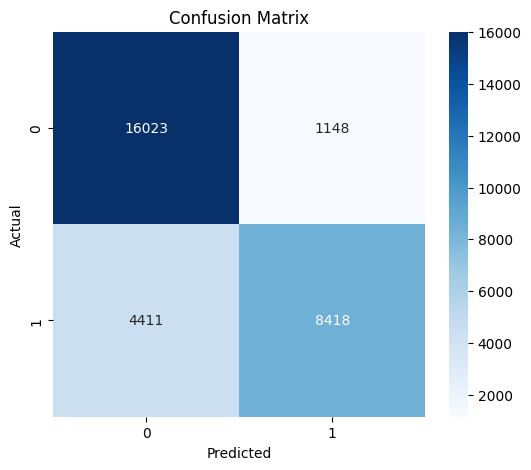

BATCH 22 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3816, Val Loss: 0.3439
Epoch 2/15, Train Loss: 0.3431, Val Loss: 0.3424
Epoch 3/15, Train Loss: 0.3381, Val Loss: 0.3273
Epoch 4/15, Train Loss: 0.3313, Val Loss: 0.3123
Epoch 5/15, Train Loss: 0.3250, Val Loss: 0.3066
Epoch 6/15, Train Loss: 0.3202, Val Loss: 0.3014
Epoch 7/15, Train Loss: 0.3093, Val Loss: 0.2907
Epoch 8/15, Train Loss: 0.3030, Val Loss: 0.3020
Epoch 9/15, Train Loss: 0.2931, Val Loss: 0.2750
Epoch 10/15, Train Loss: 0.2843, Val Loss: 0.2785
Epoch 11/15, Train Loss: 0.3009, Val Loss: 0.2871
Epoch 12/15, Train Loss: 0.2906, Val Loss: 0.2738
Epoch 13/15, Train Loss: 0.2857, Val Loss: 0.2715
Epoch 14/15, Train Loss: 0.2912, Val Loss: 0.2978
Epoch 15/15, Train Loss: 0.2891, Val Loss: 0.2935
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8157
Confusion Matrix:
[[16198  1035]
 [ 4494  8273]]


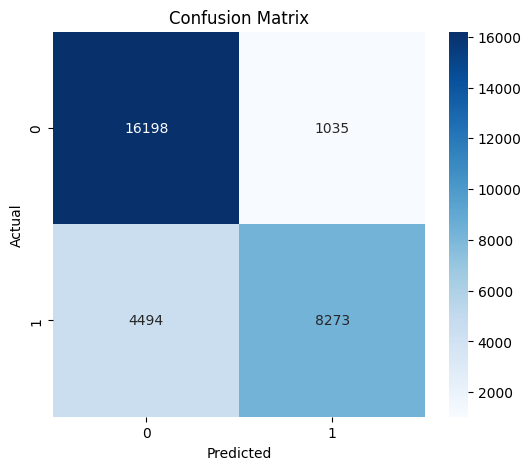

BATCH 23 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3855, Val Loss: 0.3443
Epoch 2/15, Train Loss: 0.3434, Val Loss: 0.3398
Epoch 3/15, Train Loss: 0.3430, Val Loss: 0.3348
Epoch 4/15, Train Loss: 0.3308, Val Loss: 0.3335
Epoch 5/15, Train Loss: 0.3254, Val Loss: 0.3099
Epoch 6/15, Train Loss: 0.3238, Val Loss: 0.3098
Epoch 7/15, Train Loss: 0.3157, Val Loss: 0.3118
Epoch 8/15, Train Loss: 0.3195, Val Loss: 0.3037
Epoch 9/15, Train Loss: 0.3211, Val Loss: 0.3051
Epoch 10/15, Train Loss: 0.3062, Val Loss: 0.3056
Epoch 11/15, Train Loss: 0.3139, Val Loss: 0.2881
Epoch 12/15, Train Loss: 0.2995, Val Loss: 0.2831
Epoch 13/15, Train Loss: 0.2902, Val Loss: 0.2912
Epoch 14/15, Train Loss: 0.3060, Val Loss: 0.3178
Epoch 15/15, Train Loss: 0.3052, Val Loss: 0.2787
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8078
Confusion Matrix:
[[14274  1268]
 [ 4497  9961]]


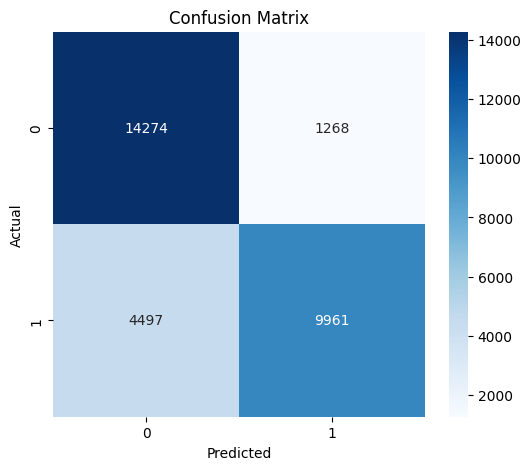

BATCH 24 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3697, Val Loss: 0.3459
Epoch 2/15, Train Loss: 0.3374, Val Loss: 0.3219
Epoch 3/15, Train Loss: 0.3275, Val Loss: 0.3121
Epoch 4/15, Train Loss: 0.3063, Val Loss: 0.2997
Epoch 5/15, Train Loss: 0.3043, Val Loss: 0.3009
Epoch 6/15, Train Loss: 0.2935, Val Loss: 0.2939
Epoch 7/15, Train Loss: 0.3062, Val Loss: 0.2911
Epoch 8/15, Train Loss: 0.2968, Val Loss: 0.2756
Epoch 9/15, Train Loss: 0.2960, Val Loss: 0.2691
Epoch 10/15, Train Loss: 0.2850, Val Loss: 0.2996
Epoch 11/15, Train Loss: 0.2915, Val Loss: 0.2719
Epoch 12/15, Train Loss: 0.2759, Val Loss: 0.2624
Epoch 13/15, Train Loss: 0.2771, Val Loss: 0.2570
Epoch 14/15, Train Loss: 0.2646, Val Loss: 0.2615
Epoch 15/15, Train Loss: 0.2781, Val Loss: 0.2656
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8082
Confusion Matrix:
[[15948   934]
 [ 4820  8298]]


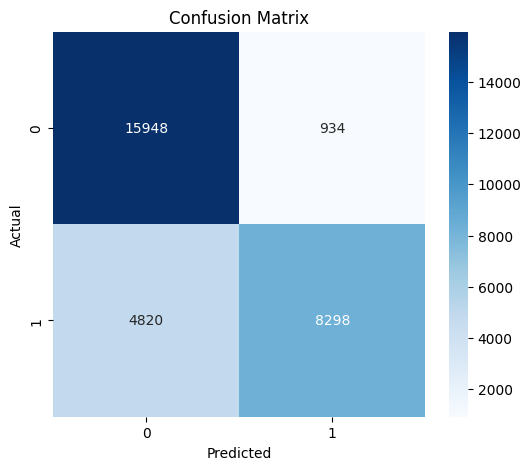

BATCH 25 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3614, Val Loss: 0.3391
Epoch 2/15, Train Loss: 0.3312, Val Loss: 0.3191
Epoch 3/15, Train Loss: 0.3247, Val Loss: 0.3174
Epoch 4/15, Train Loss: 0.3199, Val Loss: 0.3145
Epoch 5/15, Train Loss: 0.3107, Val Loss: 0.3021
Epoch 6/15, Train Loss: 0.3089, Val Loss: 0.2909
Epoch 7/15, Train Loss: 0.3069, Val Loss: 0.2839
Epoch 8/15, Train Loss: 0.2922, Val Loss: 0.2842
Epoch 9/15, Train Loss: 0.2888, Val Loss: 0.2778
Epoch 10/15, Train Loss: 0.2831, Val Loss: 0.2694
Epoch 11/15, Train Loss: 0.2753, Val Loss: 0.2618
Epoch 12/15, Train Loss: 0.2689, Val Loss: 0.2585
Epoch 13/15, Train Loss: 0.2850, Val Loss: 0.2649
Epoch 14/15, Train Loss: 0.2801, Val Loss: 0.2602
Epoch 15/15, Train Loss: 0.2600, Val Loss: 0.2503
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8173
Confusion Matrix:
[[16259  1329]
 [ 4152  8260]]


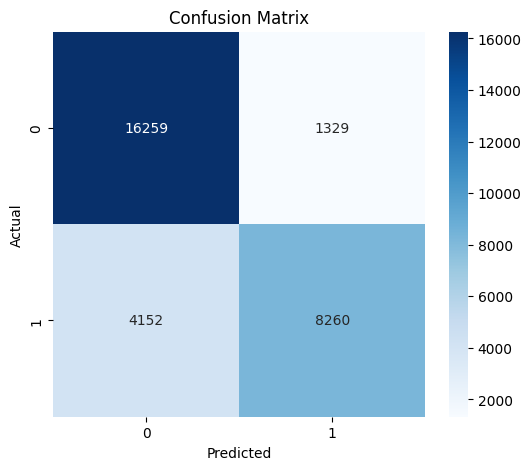

BATCH 26 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/vap_sound/src/utils/extract_mfcc_torchaudio.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)  # Shape: (time_steps,)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.3785, Val Loss: 0.3554
Epoch 2/15, Train Loss: 0.3515, Val Loss: 0.3395
Epoch 3/15, Train Loss: 0.3393, Val Loss: 0.3299
Epoch 4/15, Train Loss: 0.3256, Val Loss: 0.3069
Epoch 5/15, Train Loss: 0.3097, Val Loss: 0.3101
Epoch 6/15, Train Loss: 0.3122, Val Loss: 0.3120
Epoch 7/15, Train Loss: 0.3196, Val Loss: 0.3041
Epoch 8/15, Train Loss: 0.3090, Val Loss: 0.2896
Epoch 9/15, Train Loss: 0.2975, Val Loss: 0.2859
Epoch 10/15, Train Loss: 0.2852, Val Loss: 0.2727
Epoch 11/15, Train Loss: 0.2797, Val Loss: 0.2805
Epoch 12/15, Train Loss: 0.2809, Val Loss: 0.2552
Epoch 13/15, Train Loss: 0.2605, Val Loss: 0.2493
Epoch 14/15, Train Loss: 0.2833, Val Loss: 0.2754
Epoch 15/15, Train Loss: 0.2694, Val Loss: 0.2752
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.8017
Confusion Matrix:
[[15261  1125]
 [ 4824  8790]]


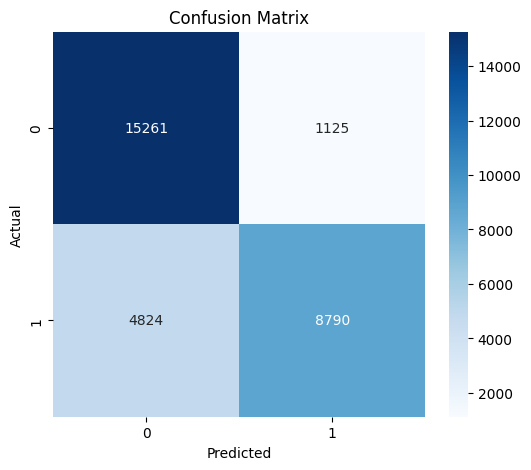

BATCH 27 out of TOTAL: 27 completed
Training Completed


In [7]:
import numpy as np
from config import MFCC_SAMPLE_RATE, FUTURE_OFFSET, HOP_LENGTH, N_MFCC_PER_FRAME, BATCH_SIZE, NUM_EPOCHS, SEQ_LENGTH, LEARNING_RATE
from utils.extract_mfcc_torchaudio import extract_mfcc_features

batch = 0
batch_file_size = 1000
total = int(len(file_df)/batch_file_size)
model = VAPModel()


for i in range(0, len(file_df)-batch_file_size, batch_file_size):

    ## Training ##
    train_files = file_df['file_paths'][i: i+batch_file_size]
    #  = extract_mfcc_features(train_files)
    training_data = extract_mfcc_features(
        audio_files=train_files, 
        target_sample_rate=MFCC_SAMPLE_RATE, 
        future_offset=FUTURE_OFFSET, 
        n_mfcc=N_MFCC_PER_FRAME, 
        hop_length=HOP_LENGTH
    )
    train_model(model, training_data, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, seq_length=SEQ_LENGTH, learning_rate=LEARNING_RATE)

    ## Evaluation
    random_integer = np.random.randint(1, len(file_df)- batch_file_size)
    eval_files = file_df['file_paths'][random_integer: random_integer + 300]
    eval_data = extract_mfcc_features(
        audio_files=eval_files, 
        target_sample_rate=MFCC_SAMPLE_RATE, 
        future_offset=FUTURE_OFFSET, 
        n_mfcc=N_MFCC_PER_FRAME, 
        hop_length=HOP_LENGTH  
    )
    eval_dataset = VAPDataset(eval_data)
    eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=True)
    evaluate_model(model, eval_dataloader, output_file=LOG_MODEL_EVALUATION, metrics_file=LOG_MODEL_PREDICTION)

    batch += 1
    print(f"BATCH {batch} out of TOTAL: {total} completed")

print("Training Completed")
    